Masks for Countries

In [ ]:
# GIVES PRIORITY TO PORTUGAL - not being used

import geopandas as gpd
import xarray as xr
import numpy as np
import os
from shapely.geometry import Point, box

# Grid parameters (same as your dataset)
lat_res = 0.75
lon_res = 0.75
lat_min, lat_max = 34.5, 66
lon_min, lon_max = -12, 36

# Create lat/lon centers for grid cells
lat_bins = np.arange(lat_min, lat_max + lat_res, lat_res)
lon_bins = np.arange(lon_min, lon_max + lon_res, lon_res)
lat_centers = lat_bins[:-1]
lon_centers = lon_bins[:-1]

# Create 2D meshgrid of pixel centers (longitude, latitude)
lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)

# Flatten to 1D arrays for point-in-polygon test
points = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T

# Input: list of shapefile paths for each region (country)
shapefile_paths = {
    "Portugal": r"E:\IPMA\Countries\PRT\gadm41_PRT_0.shp",
    "Spain": r"E:\IPMA\Countries\ESP\gadm41_ESP_0.shp",
    "Italy": r"E:\IPMA\Countries\ITA\gadm41_ITA_0.shp",
    "Greece": r"E:\IPMA\Countries\GRC\gadm41_GRC_0.shp"
}

# Load all shapefiles into GeoDataFrames
gdfs = {name: gpd.read_file(shp) for name, shp in shapefile_paths.items()}

# Ensure all shapefiles are in WGS84 (EPSG:4326)
for name, gdf in gdfs.items():
    if gdf.crs != "EPSG:4326":
        gdfs[name] = gdf.to_crs("EPSG:4326")

# Create mask arrays for each region, initialize with False
masks = {name: np.zeros(lat_grid.shape, dtype=bool) for name in gdfs}

# Keep track of pixels already assigned (to avoid overlap)
assigned_pixels = np.zeros(lat_grid.shape, dtype=bool)

from shapely.geometry import box

print("Creating pixel polygons...")

# Create pixel polygons (boxes) for each pixel center
half_lat = lat_res / 2
half_lon = lon_res / 2
pixel_polygons = [box(lon - half_lon, lat - half_lat, lon + half_lon, lat + half_lat)
                  for lon, lat in points]

print("Creating masks...")

# 1. Process Portugal and Spain first with exclusive pixel assignment
assigned_pixels = np.zeros(lat_grid.size, dtype=bool)
for name in ["Portugal", "Spain"]:
    gdf = gdfs[name]
    print(f"Processing {name} with exclusive assignment...")

    mask = np.zeros(lat_grid.size, dtype=bool)
    spatial_index = gdf.sindex

    for i, pix_poly in enumerate(pixel_polygons):
        if assigned_pixels[i]:
            continue  # skip pixels already assigned to Portugal or Spain

        possible_matches_index = list(spatial_index.intersection(pix_poly.bounds))
        possible_matches = gdf.iloc[possible_matches_index]

        # Use intersects instead of contains
        if possible_matches.geometry.apply(lambda poly: poly.intersects(pix_poly)).any():
            mask[i] = True

    assigned_pixels = assigned_pixels | mask  # both 1D boolean arrays
    masks[name] = mask.reshape(lat_grid.shape)


# 2. Process Italy and Greece without checking assigned_pixels (allow overlap)
for name in ["Italy", "Greece"]:
    gdf = gdfs[name]
    print(f"Processing {name} without exclusive assignment...")

    mask = np.zeros(lat_grid.size, dtype=bool)
    spatial_index = gdf.sindex

    for i, pix_poly in enumerate(pixel_polygons):
        possible_matches_index = list(spatial_index.intersection(pix_poly.bounds))
        possible_matches = gdf.iloc[possible_matches_index]

        if possible_matches.geometry.apply(lambda poly: poly.intersects(pix_poly)).any():
            mask[i] = True

    mask = mask.reshape(lat_grid.shape)
    masks[name] = mask


# Now save each mask as a NetCDF file matching your grid

# Define output folder for masks
output_folder = r"E:\IPMA\Countries"
os.makedirs(output_folder, exist_ok=True)

# Save masks as NetCDF
for name, mask in masks.items():
    ds_mask = xr.Dataset(
        {
            "mask": (["latitude", "longitude"], mask.astype(int))
        },
        coords={
            "latitude": lat_centers,
            "longitude": lon_centers
        },
        attrs={
            "description": f"Mask for {name}, 1=inside, 0=outside",
            "grid_resolution": f"{lat_res} x {lon_res} degrees",
            "study_area_latitude_range": f"{lat_min} to {lat_max}",
            "study_area_longitude_range": f"{lon_min} to {lon_max}"
        }
    )
    output_path = os.path.join(output_folder, f"{name}_mask.nc")
    print(f"Saving mask for {name} to {output_path}")
    ds_mask.to_netcdf(output_path)


print("Done creating masks.")


In [ ]:
#PIORITY OF WHO HAS BIGGER AREA INSIDE PIXEL - not being used

import geopandas as gpd
import xarray as xr
import numpy as np
import os
from shapely.geometry import box

# Grid parameters
lat_res = 0.75
lon_res = 0.75
lat_min, lat_max = 34.5, 66.01
lon_min, lon_max = -12, 36.01

# Create lat/lon centers
lat_bins = np.arange(lat_min, lat_max + lat_res, lat_res)
lon_bins = np.arange(lon_min, lon_max + lon_res, lon_res)
lat_centers = lat_bins[:-1]
lon_centers = lon_bins[:-1]
lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)
points = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T

# Shapefiles
shapefile_paths = {
    "Portugal": r"D:\IPMA\Countries\PRT\gadm41_PRT_0.shp",
    "Spain": r"D:\IPMA\Countries\ESP\gadm41_ESP_0_final.shp",
    "Italy": r"D:\IPMA\Countries\ITA\gadm41_ITA_0.shp",
    "Greece": r"D:\IPMA\Countries\GRC\gadm41_GRC_0.shp"
}

# Load and reproject shapefiles
gdfs = {name: gpd.read_file(path) for name, path in shapefile_paths.items()}
for name in gdfs:
    if gdfs[name].crs != "EPSG:4326":
        gdfs[name] = gdfs[name].to_crs("EPSG:4326")

# Create pixel polygons
half_lat = lat_res / 2
half_lon = lon_res / 2
pixel_polygons = [box(lon - half_lon, lat - half_lat, lon + half_lon, lat + half_lat)
                  for lon, lat in points]

# Initialize empty masks
masks = {name: np.zeros(lat_grid.size, dtype=bool) for name in shapefile_paths}

# Spatial indexes
sidx = {name: gdf.sindex for name, gdf in gdfs.items()}

# --- Step 1: Assign Portugal/Spain based on max area ---
print("Assigning Portugal/Spain by max overlap area...")
for i, pix_poly in enumerate(pixel_polygons):
    areas = {}
    for name in ["Portugal", "Spain"]:
        gdf = gdfs[name]
        possible_matches_idx = list(sidx[name].intersection(pix_poly.bounds))
        matches = gdf.iloc[possible_matches_idx]
        inter_areas = matches.geometry.intersection(pix_poly).area
        total_area = inter_areas.sum()
        if total_area > 0:
            areas[name] = total_area
    if areas:
        winner = max(areas, key=areas.get)
        masks[winner][i] = True

# --- Step 2: Process Italy/Greece normally ---
print("Processing Italy and Greece...")
for name in ["Italy", "Greece"]:
    gdf = gdfs[name]
    mask = np.zeros(len(points), dtype=bool)
    for i, pix_poly in enumerate(pixel_polygons):
        possible_matches_index = list(sidx[name].intersection(pix_poly.bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        if possible_matches.geometry.apply(lambda poly: poly.intersects(pix_poly)).any():
            mask[i] = True
    masks[name] = mask

# --- Save each mask as NetCDF ---
output_folder = r"D:\IPMA\Countries"
os.makedirs(output_folder, exist_ok=True)

for name, mask in masks.items():
    ds_mask = xr.Dataset(
        {
            "mask": (["latitude", "longitude"], mask.reshape(lat_grid.shape).astype(int))
        },
        coords={
            "latitude": lat_centers,
            "longitude": lon_centers
        },
        attrs={
            "description": f"Mask for {name}, 1=inside, 0=outside",
            "grid_resolution": f"{lat_res} x {lon_res} degrees",
            "study_area_latitude_range": f"{lat_min} to {lat_max}",
            "study_area_longitude_range": f"{lon_min} to {lon_max}"
        }
    )
    path = os.path.join(output_folder, f"{name}_mask.nc")
    print(f"Saving mask for {name} to {path}")
    ds_mask.to_netcdf(path)

print("Done.")


In [ ]:
##PIORITY OF WHO HAS BIGGER AREA INSIDE PIXEL + CREATES IBERIA - currently being used

import geopandas as gpd
import xarray as xr
import numpy as np
import os
from shapely.geometry import box

# Grid parameters
lat_res = 0.75
lon_res = 0.75
lat_min, lat_max = 34.5, 66.01
lon_min, lon_max = -12, 36.01

# Create lat/lon centers
lat_bins = np.arange(lat_min, lat_max + lat_res, lat_res)
lon_bins = np.arange(lon_min, lon_max + lon_res, lon_res)
lat_centers = lat_bins[:-1]
lon_centers = lon_bins[:-1]
lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)
points = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T

# Shapefiles
shapefile_paths = {
    "Portugal": r"D:\IPMA\Countries\PRT\gadm41_PRT_0.shp",
    "Spain": r"D:\IPMA\Countries\ESP\gadm41_ESP_0_final.shp",
    "Italy": r"D:\IPMA\Countries\ITA\gadm41_ITA_0.shp",
    "Greece": r"D:\IPMA\Countries\GRC\gadm41_GRC_0.shp"
}

# Load and reproject shapefiles
gdfs = {name: gpd.read_file(path) for name, path in shapefile_paths.items()}
for name in gdfs:
    if gdfs[name].crs != "EPSG:4326":
        gdfs[name] = gdfs[name].to_crs("EPSG:4326")

# Create pixel polygons
half_lat = lat_res / 2
half_lon = lon_res / 2
pixel_polygons = [box(lon - half_lon, lat - half_lat, lon + half_lon, lat + half_lat)
                  for lon, lat in points]

# Initialize empty masks
masks = {name: np.zeros(lat_grid.size, dtype=bool) for name in shapefile_paths}

# Spatial indexes
sidx = {name: gdf.sindex for name, gdf in gdfs.items()}

# --- Step 1: Assign Portugal/Spain based on max area ---
print("Assigning Portugal/Spain by max overlap area...")
for i, pix_poly in enumerate(pixel_polygons):
    areas = {}
    for name in ["Portugal", "Spain"]:
        gdf = gdfs[name]
        possible_matches_idx = list(sidx[name].intersection(pix_poly.bounds))
        matches = gdf.iloc[possible_matches_idx]
        inter_areas = matches.geometry.intersection(pix_poly).area
        total_area = inter_areas.sum()
        if total_area > 0:
            areas[name] = total_area
    if areas:
        winner = max(areas, key=areas.get)
        masks[winner][i] = True

# --- Step 2: Process Italy/Greece normally ---
print("Processing Italy and Greece...")
for name in ["Italy", "Greece"]:
    gdf = gdfs[name]
    mask = np.zeros(len(points), dtype=bool)
    for i, pix_poly in enumerate(pixel_polygons):
        possible_matches_index = list(sidx[name].intersection(pix_poly.bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        if possible_matches.geometry.apply(lambda poly: poly.intersects(pix_poly)).any():
            mask[i] = True
    masks[name] = mask

# --- Step 3: Create Iberian Peninsula mask ---
print("Creating Iberian Peninsula mask...")
iberia_mask = np.logical_or(masks["Portugal"], masks["Spain"])
masks["Iberia"] = iberia_mask

# --- Save each mask as NetCDF ---
output_folder = r"D:\IPMA\Countries"
os.makedirs(output_folder, exist_ok=True)

for name, mask in masks.items():
    ds_mask = xr.Dataset(
        {
            "mask": (["latitude", "longitude"], mask.reshape(lat_grid.shape).astype(int))
        },
        coords={
            "latitude": lat_centers,
            "longitude": lon_centers
        },
        attrs={
            "description": f"Mask for {name}, 1=inside, 0=outside",
            "grid_resolution": f"{lat_res} x {lon_res} degrees",
            "study_area_latitude_range": f"{lat_min} to {lat_max}",
            "study_area_longitude_range": f"{lon_min} to {lon_max}"
        }
    )
    path = os.path.join(output_folder, f"{name}_mask.nc")
    print(f"Saving mask for {name} to {path}")
    ds_mask.to_netcdf(path)

print("Done.")


Assigning Portugal/Spain by max overlap area...


C:\Users\sofia\AppData\Local\Temp\ipykernel_16628\1231859708.py:57: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  inter_areas = matches.geometry.intersection(pix_poly).area


Processing Italy and Greece...
Creating Iberian Peninsula mask...
Saving mask for Portugal to D:\IPMA\Countries\Portugal_mask.nc
Saving mask for Spain to D:\IPMA\Countries\Spain_mask.nc
Saving mask for Italy to D:\IPMA\Countries\Italy_mask.nc
Saving mask for Greece to D:\IPMA\Countries\Greece_mask.nc
Saving mask for Iberia to D:\IPMA\Countries\Iberia_mask.nc
Done.


Pixel counts per country:
Portugal: 24
Spain: 125
Italy: 120
Greece: 83


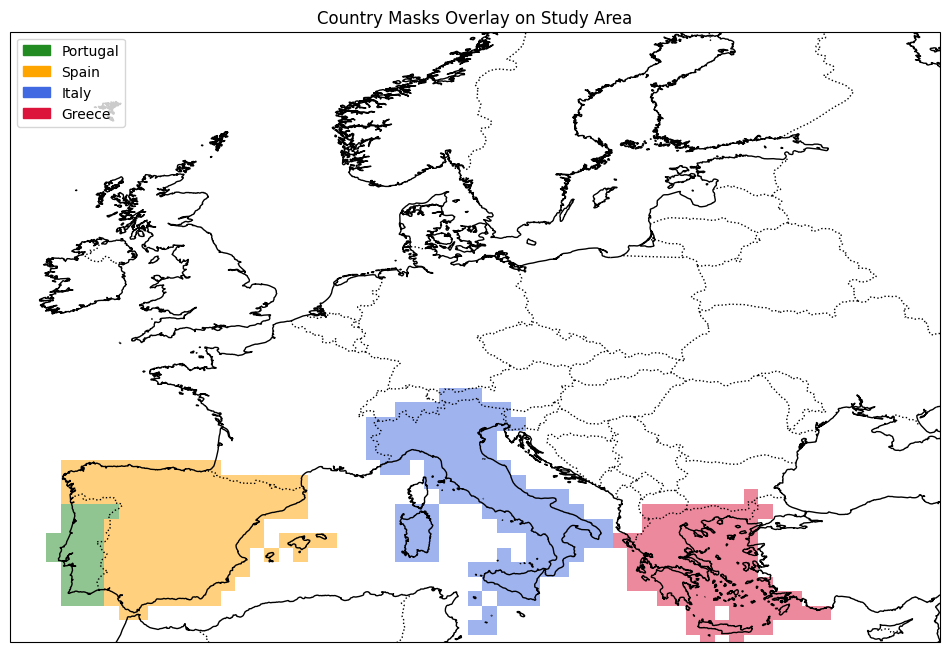

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
from matplotlib.colors import ListedColormap

# --- Set your study area extent ---
lat_min, lat_max = 34.5, 66.01
lon_min, lon_max = -12, 36.01

# --- Paths to mask NetCDF files ---
# Update these paths if needed
mask_dir = r"D:\IPMA\Countries"  # folder where your mask files are saved

mask_files = {
    "Portugal": os.path.join(mask_dir, "Portugal_mask.nc"),
    "Spain": os.path.join(mask_dir, "Spain_mask.nc"),
    "Italy": os.path.join(mask_dir, "Italy_mask.nc"),
    "Greece": os.path.join(mask_dir, "Greece_mask.nc"),
}

# --- Load masks into dict ---
masks = {country: xr.open_dataset(path) for country, path in mask_files.items()}

# --- Count pixels per region ---
pixel_counts = {}
for country, ds in masks.items():
    mask = ds['mask']
    # Assuming mask is 1 for inside country, 0 for outside
    count = int(mask.where(mask == 1).count())
    pixel_counts[country] = count

print("Pixel counts per country:")
for c, n in pixel_counts.items():
    print(f"{c}: {n}")

# --- Plot ---
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot each mask with transparency and different color
colors = {
    "Portugal": "forestgreen",
    "Spain": "orange",
    "Italy": "royalblue",
    "Greece": "crimson",
}

for country, ds in masks.items():
    mask = ds['mask']  # variable name depends on your dataset, adjust if different
    # Plot mask where value == 1
    mask_plot = mask.where(mask == 1)
    # Plot mask manually using pcolormesh and specific color
    cmap = ListedColormap([colors[country]])
    ax.pcolormesh(
        mask['longitude'], mask['latitude'], mask_plot,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        alpha=0.5,
        rasterized=True,
    )

# Add coastlines and borders
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set map extent to your study area
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Legend manually (since pcolormesh doesn’t create legend automatically)
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=colors[c], label=c) for c in masks.keys()]
plt.legend(handles=patches, loc='upper left')

plt.title("Country Masks Overlay on Study Area")
plt.show()


Study Areas

In [ ]:
# To obtain every study area needed and its respective coordinates
# North, West, South, East

#general_study_area
lat_max, lon_min, lat_min, lon_max = 66, -12, 34, 36

#portugal_area
lat_max, lon_min, lat_min, lon_max = 43, -10, 36, -6

#iberia_area
lat_max, lon_min, lat_min, lon_max = 45, -10, 35, 5

#south_europe
lat_max, lon_min, lat_min, lon_max = 45, -10, 34, 29

#greece
lat_max, lon_min, lat_min, lon_max = 42, 19, 34, 29

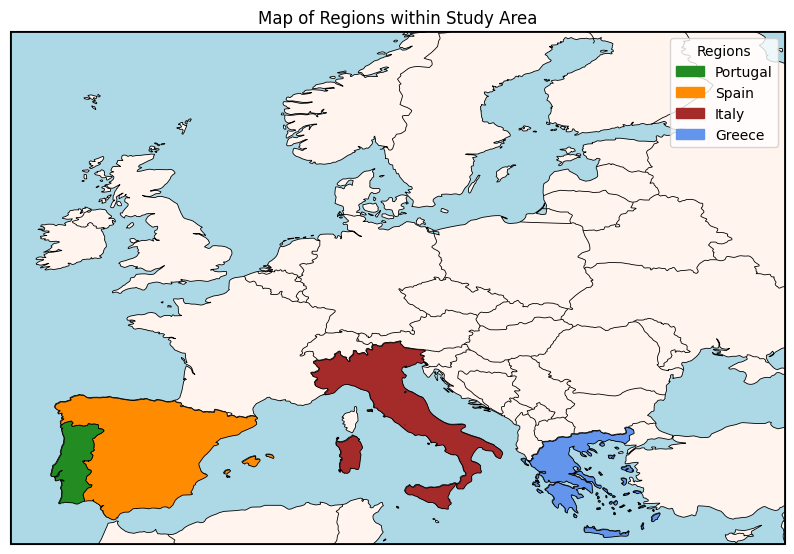

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader

# Define countries and their colors
country_colors = {
    "Portugal": "forestgreen",
    "Spain": "darkorange",
    "Italy": "brown",
    "Greece": "cornflowerblue",
}

# Study Area bounds (lat_min, lat_max, lon_min, lon_max)
study_area_bounds = (34.5, 66.25, -12, 36)

# Setup plot
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-12, 36, 34.5, 66.25], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw Study Area boundary (no fill, just edge)
lat_min, lat_max, lon_min, lon_max = study_area_bounds
ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        color='black', linewidth=2, label='Study Area')

# Load countries shapefile
shpfilename = shapereader.natural_earth(resolution='50m',
                                       category='cultural',
                                       name='admin_0_countries')
reader = shapereader.Reader(shpfilename)

# Plot each country with assigned color
handles = []
for record in reader.records():
    country_name = record.attributes['NAME_LONG']
    geom = record.geometry

    if country_name in country_colors:
        patch = ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                                 facecolor=country_colors[country_name],
                                 edgecolor='black', linewidth=0.6)
        handles.append(patch)

# Create custom legend handles for the countries
import matplotlib.patches as mpatches
legend_handles = [mpatches.Patch(color=color, label=country) for country, color in country_colors.items()]

# Add legend with title 'Regions'
plt.legend(handles=legend_handles, loc='upper right', title='Regions')

plt.title('Map of Regions within Study Area')
plt.show()

